# TRABAJO PRACTICO 3

Integrantes:
- Pedro Lucas Barrera
- Lautaro Gabriel Medina 

In [3]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import os

## Punto 1

Se encontraron 7 imágenes para procesar

Procesando imagen: COCA-COLA-LOGO.jpg

Procesando imagen: coca_logo_1.png

Procesando imagen: coca_logo_2.png

Procesando imagen: coca_multi.png

Procesando imagen: coca_retro_1.png

Procesando imagen: coca_retro_2.png

Procesando imagen: logo_1.png


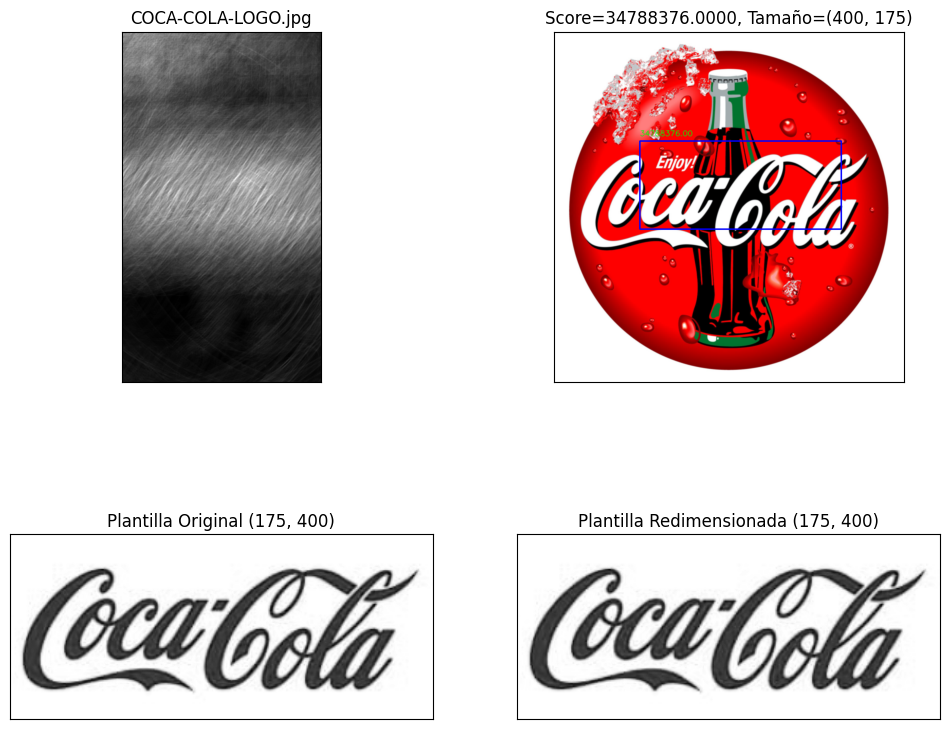

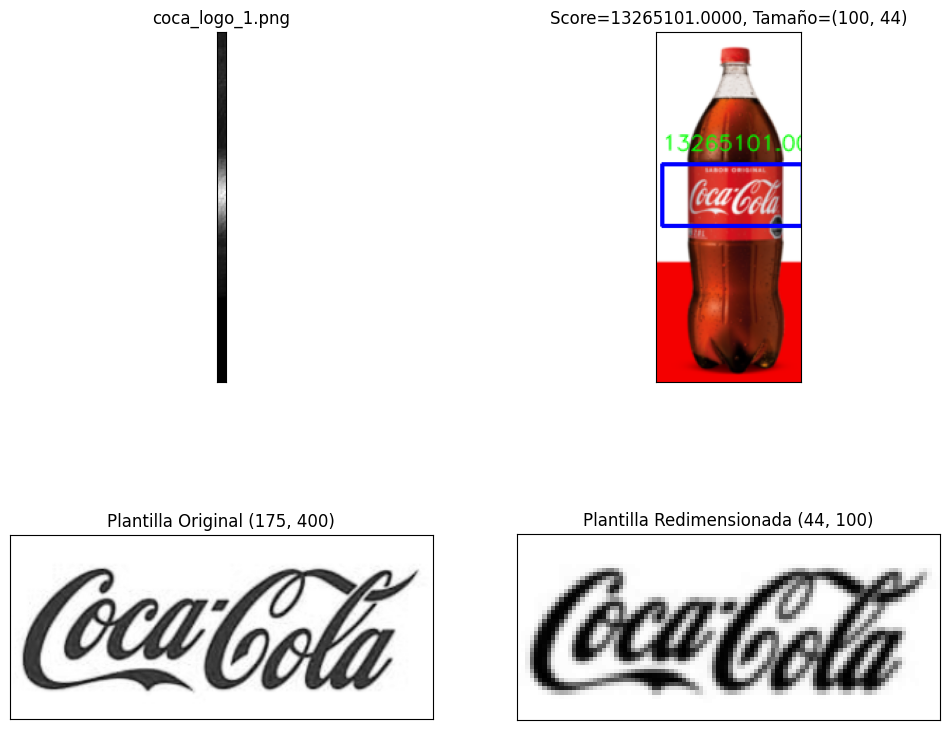

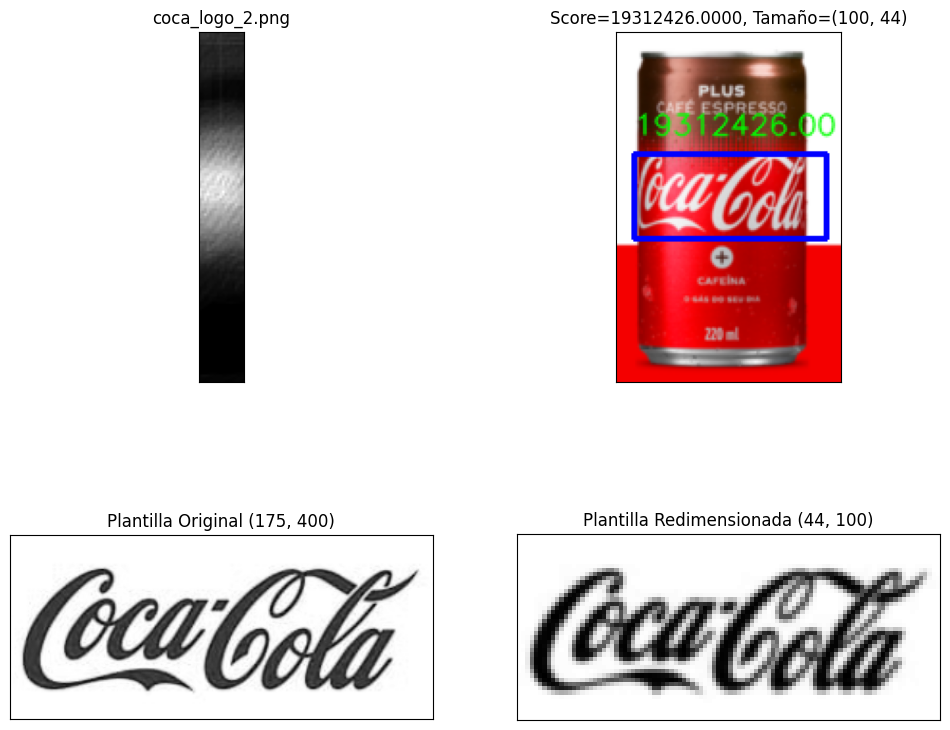

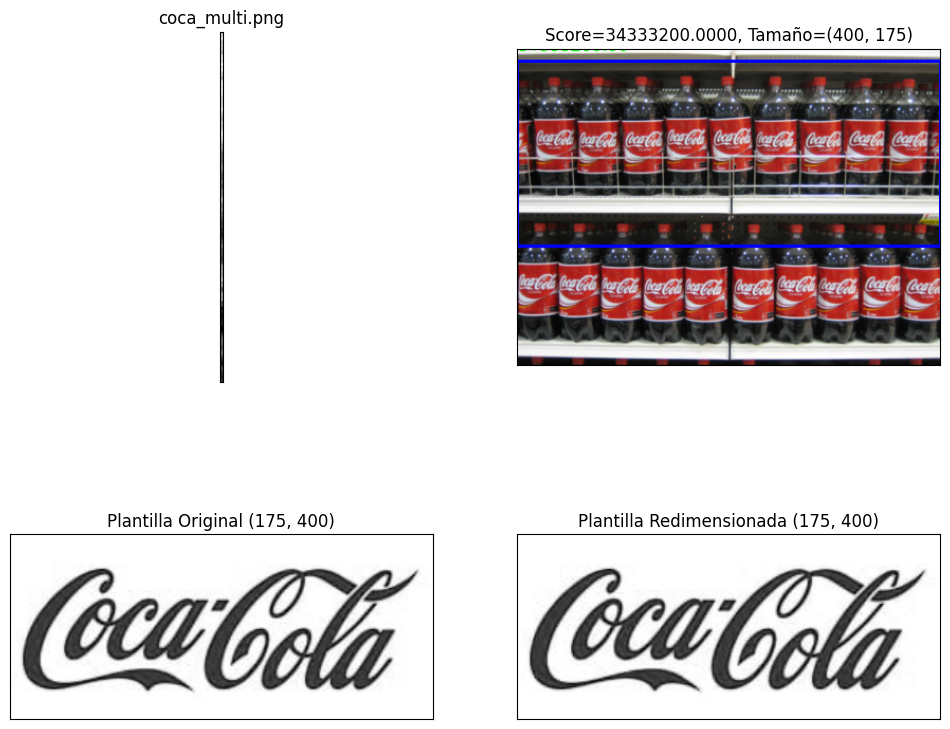

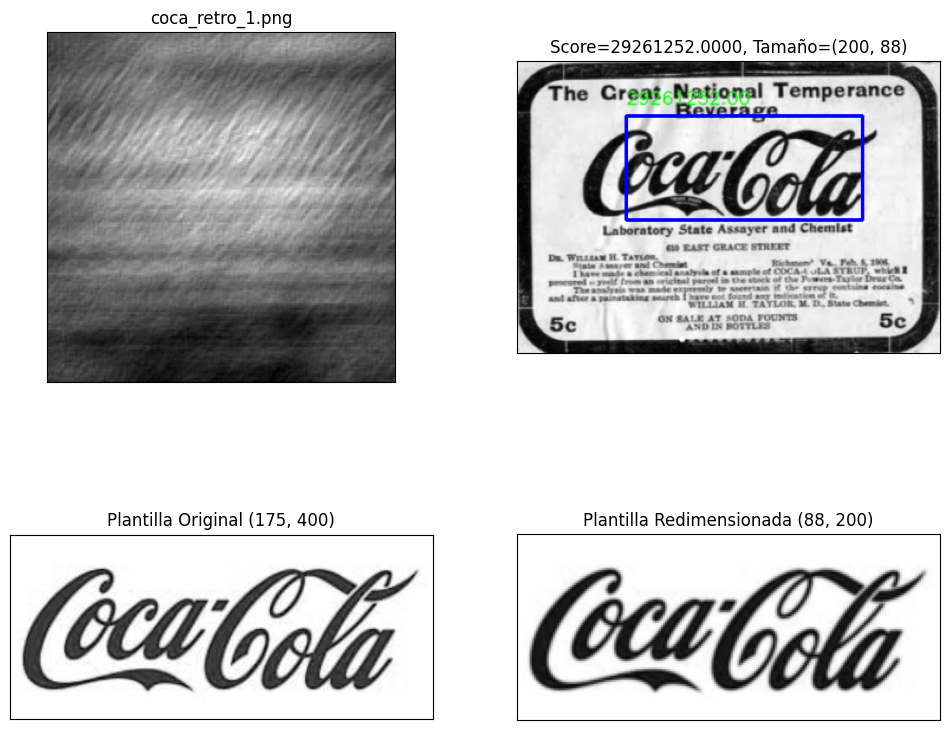

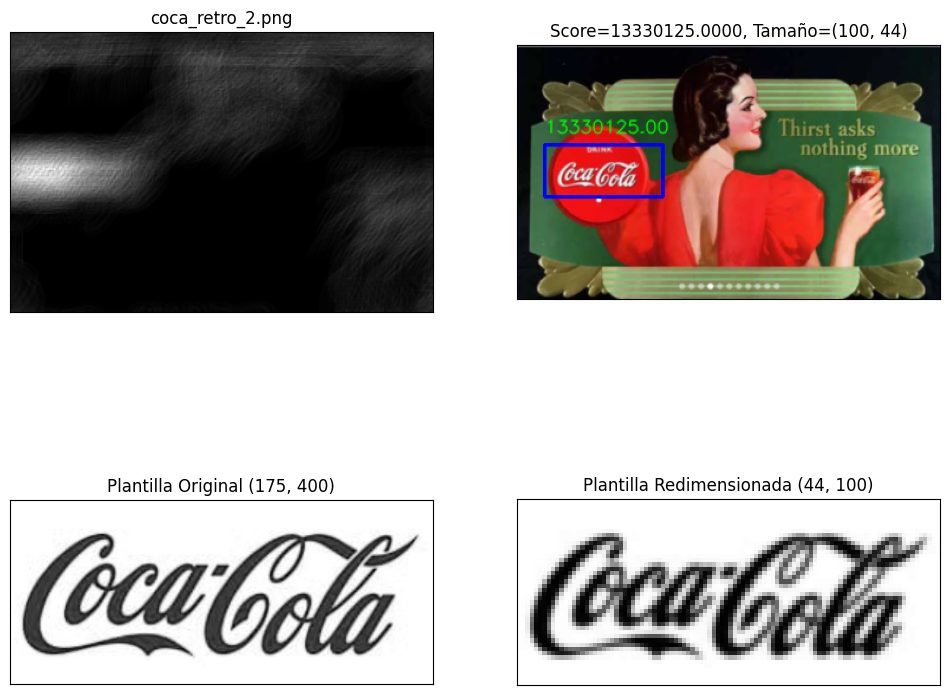

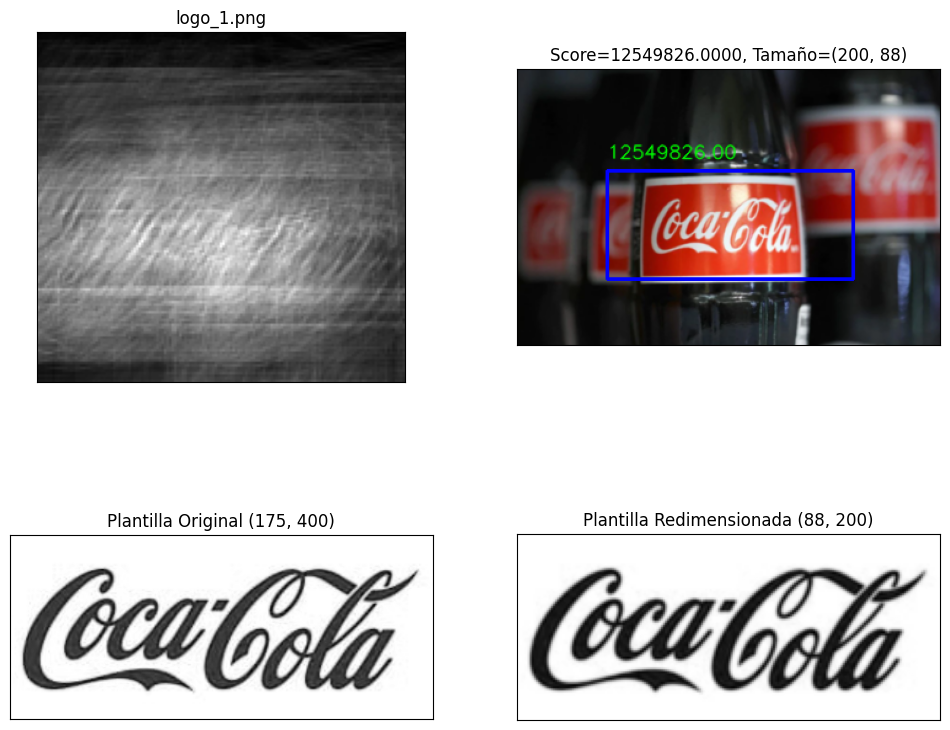

In [4]:
images_folder = r'Imagenes'
# Carga de la plantilla
template = cv.imread(r'pattern.png', 0)

# Obtener lista de imágenes
image_files = [f for f in os.listdir(images_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
print(f"Se encontraron {len(image_files)} imágenes para procesar")

method = cv.TM_CCORR


# Procesar cada imagen
for image_file in image_files:
    image_path = os.path.join(images_folder, image_file)
    print(f"\nProcesando imagen: {image_file}")
    
    # Cargar imagen
    img = cv.imread(image_path)
    if img is None:
        print(f"No se pudo cargar la imagen {image_file}, saltando...")
        continue
        
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img_gray = cv.pyrDown(img_gray)
    img_gray = cv.Canny(img_gray, 300, 600) #300 700
    
    
    # Número máximo de niveles piramidales
    max_pyr_levels = 10 

    best_score = float('-inf')
    best_result = None
    best_template_size = None
    best_template = None
    best_location = None
    best_scale = None
    
    for level in range(max_pyr_levels + 1):
        resized_template = template.copy()

        for _ in range(level):
            resized_template = cv.pyrDown(resized_template)
        
        new_h, new_w = resized_template.shape
        if new_w > img_gray.shape[1] or new_h > img_gray.shape[0] or new_w < 5 or new_h < 5:
            continue  # Ignora plantillas muy chicas o más grandes que la imagen
        
        try:
            res = cv.matchTemplate(img_gray, cv.Canny(resized_template, 50, 200), method)
        except Exception as e:
            print(f"  Error con nivel piramidal {level}: {e}")
            continue
        
        min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)

        score = max_val
        top_left = max_loc
        
        is_better = score > best_score
        
        if is_better:
            best_score = score
            best_result = res
            best_template_size = (new_w, new_h)
            best_template = resized_template
            best_location = top_left
            best_scale = resized_template.shape[1] / template.shape[1]  # ancho relativo

    img_salida = cv.pyrDown(img_rgb.copy())
    w, h = best_template_size
    top_left = best_location
    bottom_right = (top_left[0] + w, top_left[1] + h)
    cv.rectangle(img_salida, top_left, bottom_right, (0, 0, 255), 2)  # Rectángulo azul
    score_text = f'{best_score:.2f}'
    cv.putText(img_salida, score_text, (top_left[0], top_left[1] - 10), 
    cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1, cv.LINE_AA)
    
    plt.figure(figsize=(12, 10))
        
    # Use a 2x2 grid
    plt.subplot(221)
    plt.imshow(best_result, cmap='gray')
    plt.title(f'{image_file}')
    plt.xticks([]), plt.yticks([])

    plt.subplot(222)
    plt.imshow(img_salida)
    plt.title(f'Score={best_score:.4f}, Tamaño={best_template_size}')
    plt.xticks([]), plt.yticks([])

    plt.subplot(223)
    plt.imshow(template, cmap='gray')
    plt.title(f'Plantilla Original {template.shape}')
    plt.xticks([]), plt.yticks([])

    plt.subplot(224)
    plt.imshow(best_template, cmap='gray')
    plt.title(f'Plantilla Redimensionada {best_template.shape}')
    plt.xticks([]), plt.yticks([])

## PUNTO 2

cv.TM_CCORR_NORMED


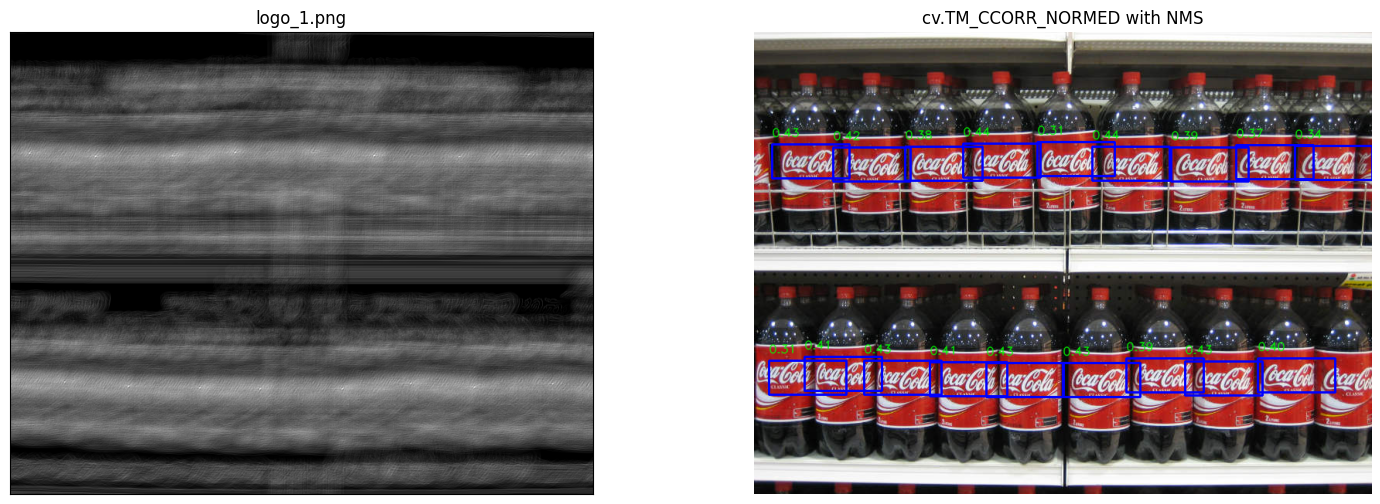

Template size: 100 44


In [5]:
img_rgb = cv.imread('Imagenes\coca_multi.png')
img_rgb = cv.cvtColor(img_rgb, cv.COLOR_BGR2RGB)
img_gray = cv.cvtColor(img_rgb, cv.COLOR_BGR2GRAY)
img_gray = cv.Canny(img_gray, 100, 400)
template = cv.imread('pattern.png',0)
template = cv.pyrDown(template)
template = cv.pyrDown(template)
template = cv.Canny(template, 100, 200)

method = 'cv.TM_CCORR_NORMED'

method_cv = eval(method)
w, h = template.shape[::-1]
print(method)
res = cv.matchTemplate(img_gray,template,method_cv)

threshold = 0.3
boxes = []
confidences = []
loc = np.where(res >= threshold)
for pt in zip(*loc[::-1]):
    x = int(pt[0])
    y = int(pt[1])
    boxes.append([x, y, w, h])
    confidences.append(float(res[y, x]))

# Aplico Non-Maximum Suppression (NMS)
nms_threshold = 0.35 

indices = cv.dnn.NMSBoxes(boxes, confidences, threshold, nms_threshold)

# Create a display copy and draw the filtered boxes
img_display = img_rgb.copy()
for idx in indices:
    
    i = idx[0] if isinstance(idx, (list, tuple, np.ndarray)) else idx
    x, y, w_box, h_box = boxes[i]
    cv.rectangle(img_display, (x, y), (x + w_box, y + h_box), (0, 0, 255), 2)
    
    # Mostrar el score (confianza) en el recuadro
    score_text = f'{confidences[i]:.2f}'
    cv.putText(img_display, score_text, (x, y - 10), 
    cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1, cv.LINE_AA)
    
plt.figure(figsize=(18, 6))
plt.subplot(121)
plt.imshow(res, cmap='gray')
plt.title(f'{image_file}')
plt.xticks([]), plt.yticks([])
plt.subplot(122)
plt.imshow(img_display)
plt.title(method + " with NMS")
plt.axis("off")
plt.show()
print("Template size:", w, h)

## PUNTO 3

Se encontraron 7 imágenes para procesar

Procesando imagen: COCA-COLA-LOGO.jpg


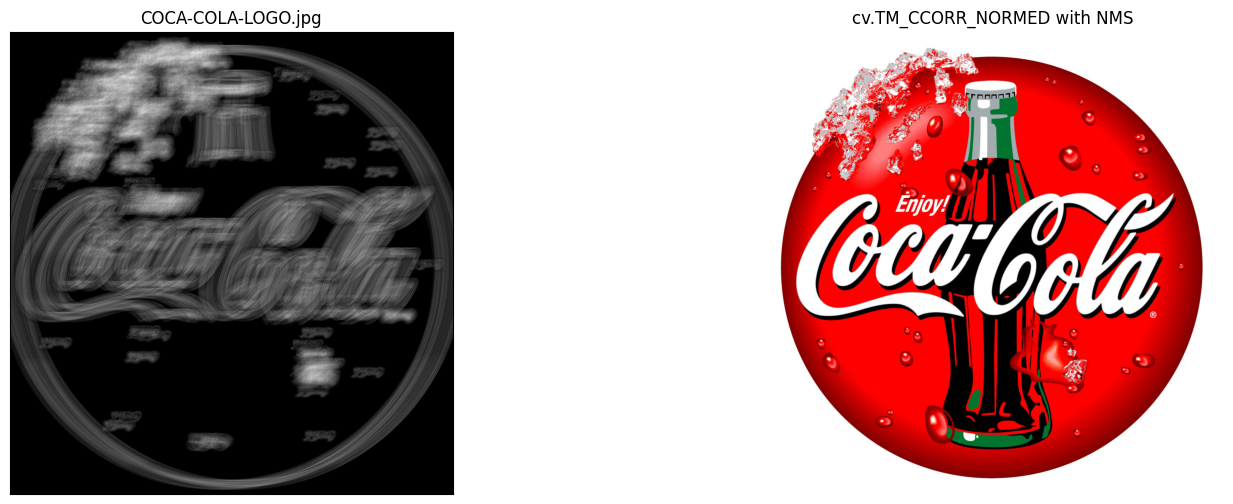

Template size: (100, 44)

Procesando imagen: coca_logo_1.png


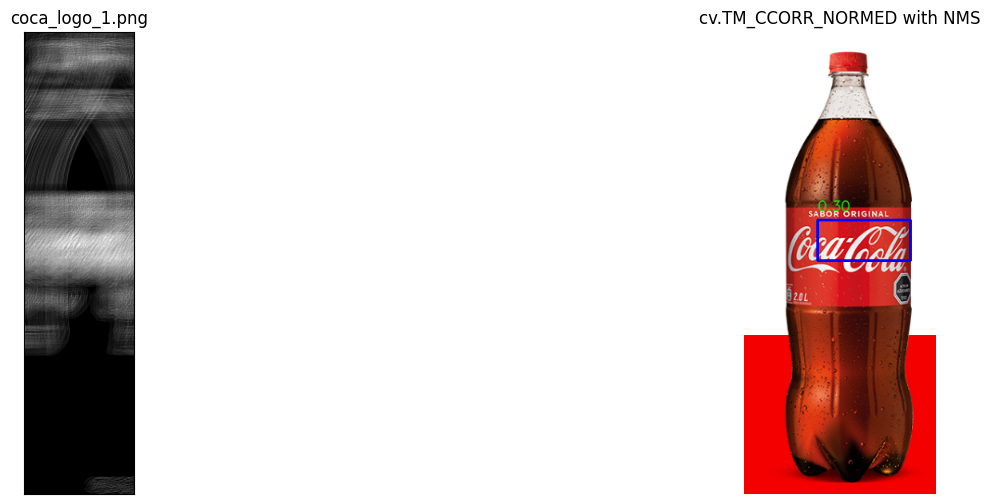

Template size: (100, 44)

Procesando imagen: coca_logo_2.png


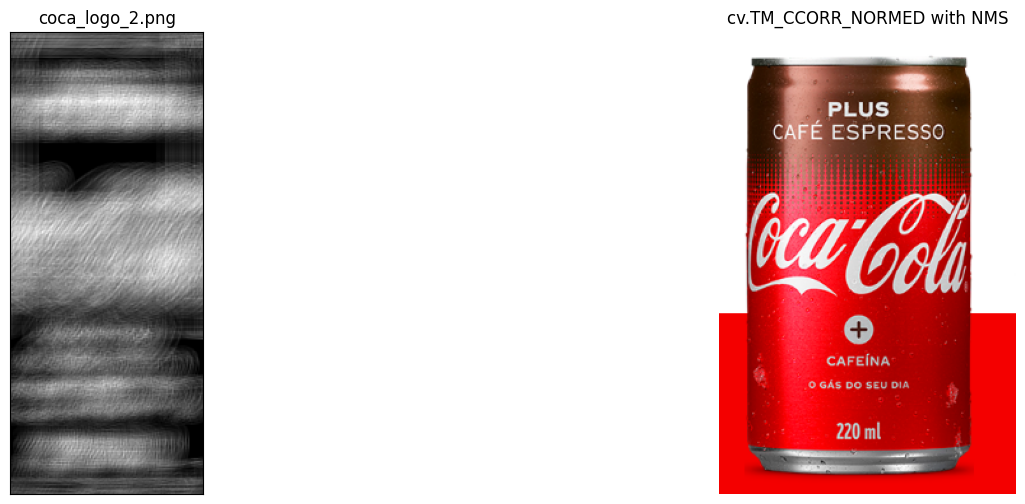

Template size: (100, 44)

Procesando imagen: coca_multi.png


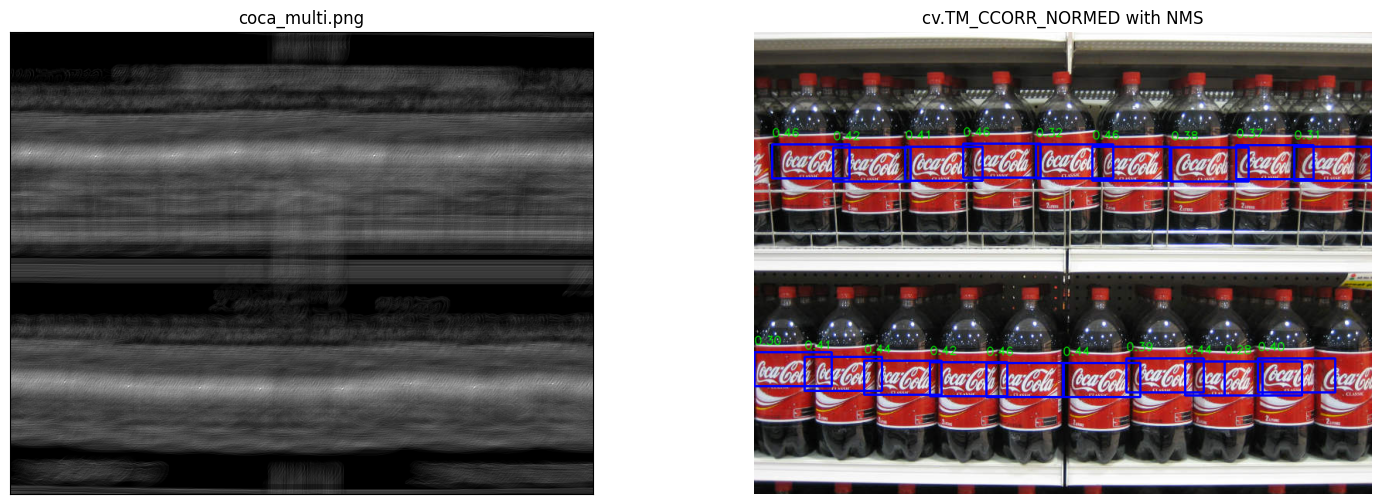

Template size: (100, 44)

Procesando imagen: coca_retro_1.png


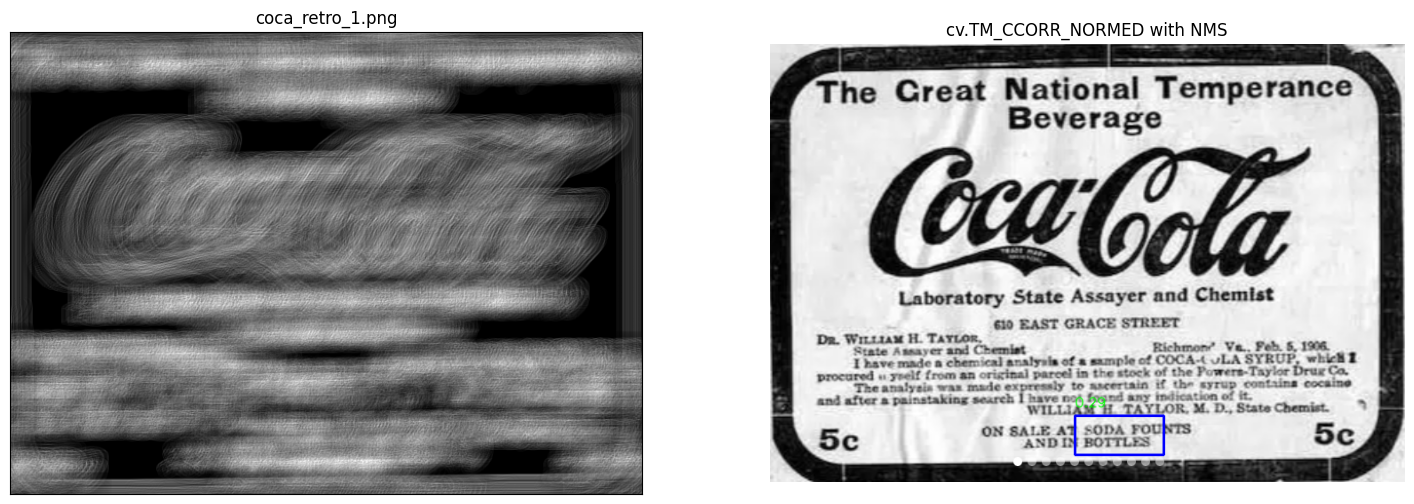

Template size: (100, 44)

Procesando imagen: coca_retro_2.png


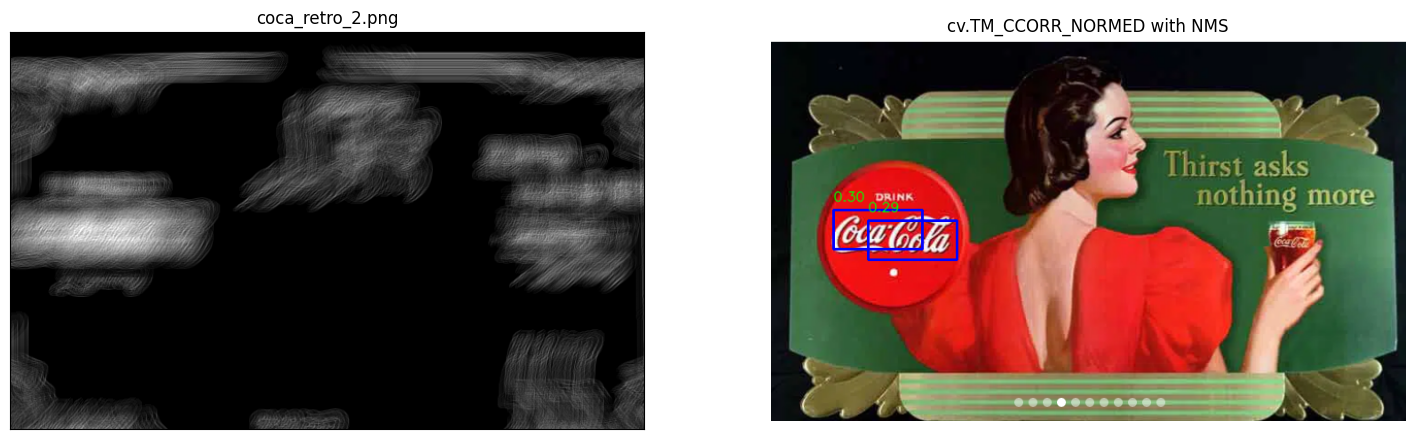

Template size: (100, 44)

Procesando imagen: logo_1.png


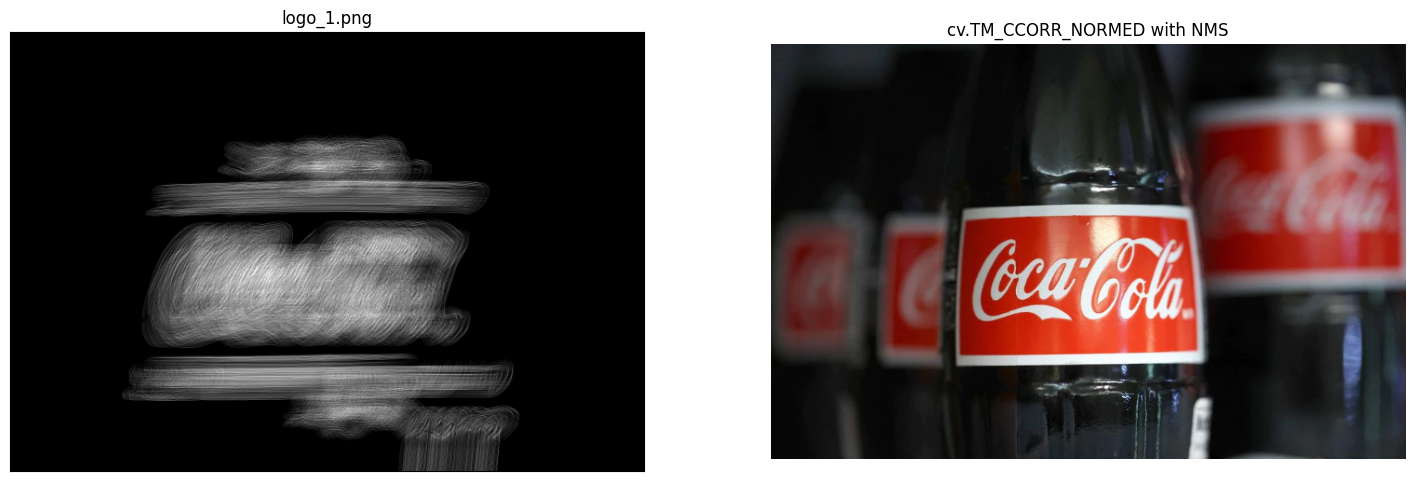

Template size: (100, 44)


In [6]:
images_folder = r'Imagenes'
template = cv.imread(r'pattern.png', 0)

# Obtener lista de imágenes
image_files = [f for f in os.listdir(images_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
print(f"Se encontraron {len(image_files)} imágenes para procesar")

method = cv.TM_CCORR_NORMED

# Procesar cada imagen
for image_file in image_files:
    image_path = os.path.join(images_folder, image_file)
    print(f"\nProcesando imagen: {image_file}")
    
    # Cargar imagen
    img = cv.imread(image_path)
    if img is None:
        print(f"No se pudo cargar la imagen {image_file}, saltando...")
        continue
        
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img_gray = cv.Canny(img_gray, 300, 600) 
    
    
    # Número máximo de niveles piramidales
    max_pyr_levels = 2 

    best_score = float('-inf')
    best_result = None
    best_template_size = None
    best_template = None
    best_location = None
    best_scale = None
    
    for level in range(max_pyr_levels + 1):
        resized_template = template.copy()

        for _ in range(level):
            resized_template = cv.pyrDown(resized_template)
        
        new_h, new_w = resized_template.shape
        if new_w > img_gray.shape[1] or new_h > img_gray.shape[0] or new_w < 5 or new_h < 5:
            continue  # Ignora plantillas muy chicas o más grandes que la imagen
        
        try:
            res = cv.matchTemplate(img_gray, cv.Canny(resized_template, 50, 200), method)
        except Exception as e:
            print(f"  Error con nivel piramidal {level}: {e}")
            continue
        
        min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)

        score = max_val
        top_left = max_loc
        
        is_better = score > best_score
        
        if is_better:
            best_score = score
            best_result = res
            best_template_size = (new_w, new_h)
            best_template = resized_template
            best_location = top_left
            best_scale = resized_template.shape[1] / template.shape[1]  # ancho relativo

    threshold = 0.28
    boxes = []
    confidences = []
    loc = np.where(best_result >= threshold)
    for pt in zip(*loc[::-1]):
        x = int(pt[0])
        y = int(pt[1])
        boxes.append([x, y, best_template_size[0], best_template_size[1]])
        confidences.append(float(res[y, x]))

    # Aplico Non-Maximum Suppression (NMS)
    nms_threshold = 0.35  
    indices = cv.dnn.NMSBoxes(boxes, confidences, threshold, nms_threshold)


    img_display = img_rgb.copy()
    for idx in indices:
        i = idx[0] if isinstance(idx, (list, tuple, np.ndarray)) else idx
        x, y, w_box, h_box = boxes[i]
        cv.rectangle(img_display, (x, y), (x + w_box, y + h_box), (0, 0, 255), 2)
        
        # Mostrar el score (confianza) en el recuadro
        score_text = f'{confidences[i]:.2f}'
        cv.putText(img_display, score_text, (x, y - 10), 
        cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1, cv.LINE_AA)
        
    plt.figure(figsize=(18, 6))
    plt.subplot(121)
    plt.imshow(best_result, cmap='gray')
    plt.title(f'{image_file}')
    plt.xticks([]), plt.yticks([])
    plt.subplot(122)
    plt.imshow(img_display)
    plt.title("cv.TM_CCORR_NORMED" + " with NMS")
    plt.axis("off")
    plt.show()
    print("Template size:", best_template_size)

## COMENTARIOS FINALES



Como podemos ver, los algoritmos que tuvieron éxito en detectar múltiples ocurrencias del patrón no tuvieron una eficaz detección en el resto de las imágenes. Adicionalmente, Durante el desarrollo del trabajo observamos que hay una diferencia en detectar ocurrencias grandes y pequeñas, particularmente aquellas de baja resolución.

Además, ciertos sectores de algunas imágenes que pueden afectar severamente la detección -como en COCA-COLA-LOGO con la espuma- pero es posible delimitar los bordes que queremos estableciendo bien los limites de cv.Canny. o usando otras técnicas como dilatación de bordes. 

Este tipo de enfoque no aporto buenos resultados, ya que optimizar la detección en una imagen empeoraba la detección en las otras, teniendo un efecto parecido al sobreajuste.
De todos modos, se consiguieron buenos resultados para las detecciones individuales y las múltiples siempre que se queden en sus propios nichos.